In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers, optimizers
from keras.optimizers import Adam, RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# File Extracting
So our file is going to be in binary and we are going to need to get it out
You can thinks of this process of encoding and decoding, but allows us to store a large number of images, and the vectors, in a much smaller file

In [2]:
# this is a dictionairy used to define the structure
# of our binary file
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'title': tf.io.FixedLenFeature([], tf.string),
    'price': tf.io.FixedLenFeature([], tf.float32),
    'unbalanced_vector': tf.io.VarLenFeature(tf.int64),
    'balanced_vector': tf.io.VarLenFeature(tf.int64),
}

In [3]:
# this is a function used to extract the binary information
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    title = tf.strings.lower(parsed_example['title'])
    price = parsed_example['price']
    unbalanced_vector = tf.sparse.to_dense(parsed_example['unbalanced_vector'])
    balanced_vector = tf.sparse.to_dense(parsed_example['balanced_vector'])
    return image, title, price, unbalanced_vector, balanced_vector

In [4]:
dataset = tf.data.TFRecordDataset('Downloaded_Images_Binary.tfrecords')
dataset = dataset.map(parse_example)


2023-11-19 20:56:30.132693: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-19 20:56:30.132731: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-19 20:56:30.132749: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-19 20:56:30.132795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 20:56:30.132822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Here some code to show we extracted everything correctly!

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
tf.Tensor(107.0, shape=(), dtype=float32)


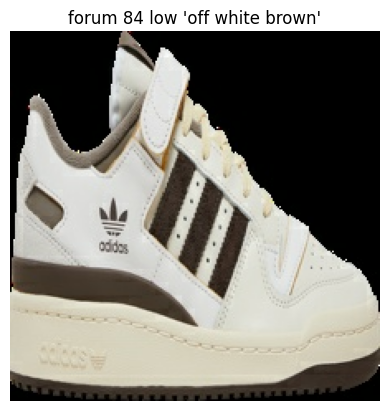

Unbalanced Vector: [1 0 0 0 0 0 0 0 0 0]
Balanced Vector: [1 0 0 0 0 0 0 0 0 0]
tf.Tensor(56.0, shape=(), dtype=float32)


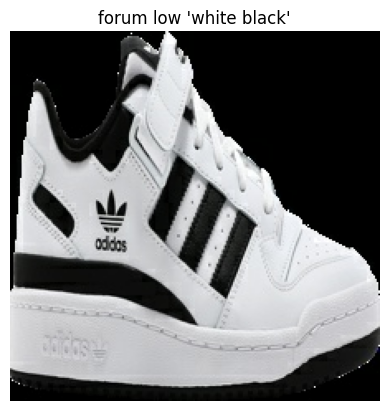

Unbalanced Vector: [1 0 0 0 0 0 0 0 0 0]
Balanced Vector: [1 0 0 0 0 0 0 0 0 0]
tf.Tensor(60.0, shape=(), dtype=float32)


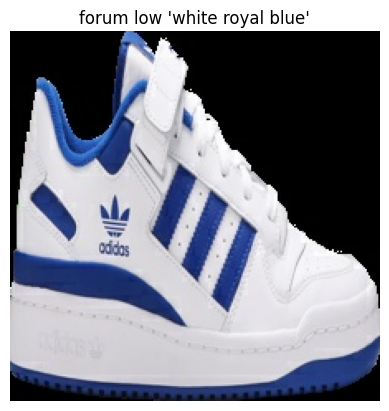

In [5]:
for image, title, price, unbalanced_vector, balanced_vector in dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

# Splitting up training and Testing Data
    * We are going to shuffle the data incase
    the website organizes the data in set, non-random
    way. 

## Base Dataset
    * No techniques except shuffling and shape!

In [6]:
# Size of Data
buffer_size = sum([1 for _ in dataset])  
# Shuffle the data
shuffled_dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
# 80/20 Split, Taking will take the first 80% and skip will take the last
train_size = int(0.8 * buffer_size)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)

## Printing it out again to make sure everything looks right!

Unbalanced Vector: [0 0 0 1 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 1 0 0]
tf.Tensor(399.0, shape=(), dtype=float32)


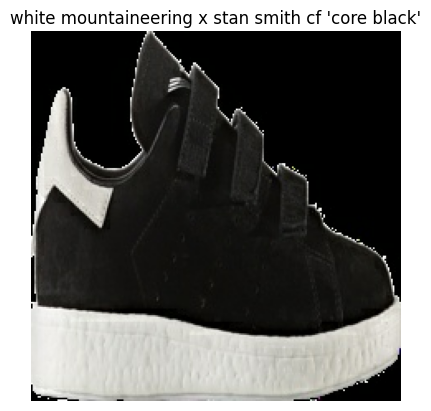

Unbalanced Vector: [0 0 0 1 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 1 0 0]
tf.Tensor(347.0, shape=(), dtype=float32)


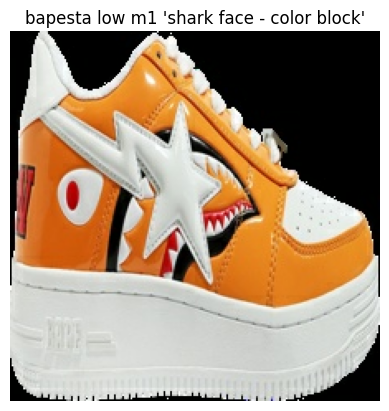

Unbalanced Vector: [0 0 0 0 0 0 0 0 0 1]
Balanced Vector: [0 0 0 0 0 0 0 0 0 1]
tf.Tensor(1507.0, shape=(), dtype=float32)


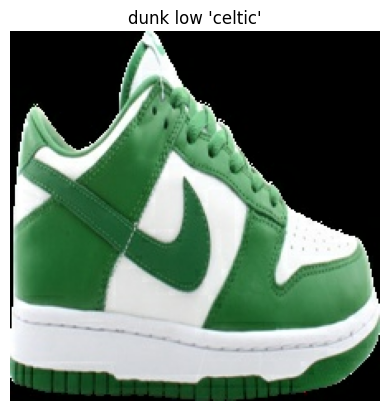

In [7]:
for image, title, price, unbalanced_vector, balanced_vector in val_dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

## Data Technique 1 - Normalization!
* This can be done simply by dividing by 255 (Pixel score)
* This will improve and is going to be necessary for vgg16

In [8]:
# This is a function to divide the image / 255, preprocess is 
# a function apart of keras and has certain rules, and it allows us to declare are predictor/response
# we are going to be using these keras functions a lot
def preprocess(image, title, price, unbalanced_vector,balanced_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

norm_train_dataset = train_dataset.map(preprocess).batch(16)
norm_val_dataset = val_dataset.map(preprocess).batch(16)

## Data Technique 2 - Data Augmentaton!
* This is a technique used to introduce variations to our training data and can have enourmouse
benefits


In [9]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, augment = True):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)  
        image = tf.image.random_flip_up_down(image)     
    return image, unbalanced_vector

aug_train_dataset = train_dataset.map(preprocess).batch(16)
aug_val_dataset = val_dataset.map(preprocess).batch(16)



# Model
We are going to be using Tensorflow and Keras to build our model. Tensflow Keras allow us to build models incredibly easly. 
Here is a model I found online. It is similiar to our problem, but is going to be very inaccurate but allows us to evalute different preprocessing techniques before working 
with the larger model. 

In [11]:
# model is linear
model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model.add(Dropout(0.2))
# (10,10,64) -> (6400)
model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
model.add(Dense(vector_size, activation='softmax'))

model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0

In [13]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model.fit(aug_train_dataset, epochs=9, validation_data=aug_val_dataset)

Epoch 1/9
    641/Unknown - 27s 39ms/step - loss: 0.3794 - accuracy: 0.2442

2023-11-19 20:58:09.314848: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16167899797631054537
2023-11-19 20:58:09.314861: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12084147619208649911
2023-11-19 20:58:09.314870: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 581234463659175131
2023-11-19 20:58:09.314876: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11561226434531554987
2023-11-19 20:58:09.314893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1341198857960378740
2023-11-19 20:58:09.314896: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 465252141969109800
2023-11-19 20:58:09.314902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

641/641 [==============================] - 30s 45ms/step - loss: 0.3794 - accuracy: 0.2442 - val_loss: 0.6252 - val_accuracy: 0.0410
Epoch 2/9


2023-11-19 20:58:12.817649: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2484991993073648409
2023-11-19 20:58:12.817669: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16872539359751055546
2023-11-19 20:58:12.817693: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3918290945974036754
2023-11-19 20:58:12.817707: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8193629537756847192
2023-11-19 20:58:12.817717: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5812628889067023364
2023-11-19 20:58:12.817725: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17010302046997261598


641/641 [==============================] - 29s 43ms/step - loss: 0.3243 - accuracy: 0.2696 - val_loss: 0.3020 - val_accuracy: 0.2319
Epoch 3/9
641/641 [==============================] - 30s 45ms/step - loss: 0.2953 - accuracy: 0.3088 - val_loss: 0.2853 - val_accuracy: 0.3158
Epoch 4/9
641/641 [==============================] - 28s 42ms/step - loss: 0.2801 - accuracy: 0.3279 - val_loss: 0.2818 - val_accuracy: 0.3099
Epoch 5/9
641/641 [==============================] - 28s 42ms/step - loss: 0.2745 - accuracy: 0.3398 - val_loss: 0.2786 - val_accuracy: 0.3165
Epoch 6/9
641/641 [==============================] - 28s 43ms/step - loss: 0.2728 - accuracy: 0.3377 - val_loss: 0.2791 - val_accuracy: 0.3201
Epoch 7/9
641/641 [==============================] - 29s 44ms/step - loss: 0.2717 - accuracy: 0.3409 - val_loss: 0.2794 - val_accuracy: 0.3158
Epoch 8/9
641/641 [==============================] - 30s 45ms/step - loss: 0.2704 - accuracy: 0.3433 - val_loss: 0.2801 - val_accuracy: 0.3154
Epoch 9/9

In [14]:
predictions = model.predict(norm_val_dataset)

# Initialize an array of zeros with the same shape as predictions
binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    binary_predictions[i, max_index] = 1

print(binary_predictions)

161/161 [==============================] - 3s 11ms/step
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


2023-11-19 21:12:23.328239: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3032693357117055754


# Evaluation

## True vs Pred
Here is some code to extract our labels and predictions. Because we are running our code on batches, we have unpack the batches, we can then covert it from a tf tensor to numpy array

In [15]:
true_labels = []
predicted_labels = []

binary_predictions_list = binary_predictions.tolist()
prediction_count = 0

for batch in norm_val_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)


(2562, 10)
(2562, 10)


In [18]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(cm)

[[136 228  34  13   2   0   0   0   0  16]
 [136 553  74  36   8   0   0   0   0  29]
 [ 34 271  65  21   3   0   0   0   0  23]
 [ 29 200  42  17   7   0   0   0   0  18]
 [ 16  88  17  12   3   0   0   0   0  14]
 [ 10  67  14   5   4   0   0   0   0   5]
 [  3  32   8   0   0   0   0   0   0  11]
 [  6  39   3   2   1   0   0   0   0   7]
 [  1   9   4   3   1   0   0   1   0   1]
 [ 19 106  20  11   2   0   0   0   0  22]]


In [17]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
report = classification_report(true_labels, predicted_labels)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(report)

Accuracy: 0.31069476971116317
Precision: 0.13163042203419142
Recall: 0.13309101916287816
F1 Score: 0.12203305989320903
              precision    recall  f1-score   support

           0       0.35      0.32      0.33       429
           1       0.35      0.66      0.46       836
           2       0.23      0.16      0.19       417
           3       0.14      0.05      0.08       313
           4       0.10      0.02      0.03       150
           5       0.00      0.00      0.00       105
           6       0.00      0.00      0.00        54
           7       0.00      0.00      0.00        58
           8       0.00      0.00      0.00        20
           9       0.15      0.12      0.13       180

   micro avg       0.31      0.31      0.31      2562
   macro avg       0.13      0.13      0.12      2562
weighted avg       0.24      0.31      0.26      2562
 samples avg       0.31      0.31      0.31      2562



/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
